In [1]:
pip install pandas numpy matplotlib seaborn scikit-learn datasets pyarrow notebook  --quiet

Note: you may need to restart the kernel to use updated packages.


### Loading Dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from datasets import load_dataset
import os

images_dir = 'C:/naira_sentry/visuals'

###  Data Download Instruction (READ ME)

**Do not run this locally!** To save bandwidth (1.8GB), we use Google Colab to download and sample the data remotely.

**Steps:**
1. Go to [Google Colab](https://colab.research.google.com).
2. Create a new notebook.
3. Copy-paste and run the code block below.
4. Download the resulting `nigeria_fraud_dataset_sample.csv` and place it in `data/raw/`.

```python

# --- RUN THIS IN GOOGLE COLAB ONLY ---
!pip install datasets pandas

from datasets import load_dataset
import pandas as pd

ds = load_dataset("electricsheepafrica/Nigerian-Financial-Transactions-and-Fraud-Detection-Dataset", split="train")

# We take a random sample so you keep the statistical properties
df_sample = ds.to_pandas().sample(500000, random_state=42)

df_sample.to_csv("nigeria_fraud_dataset_sample.csv", index=False)


In [3]:
df = pd.read_csv("C:/naira_sentry/data/raw/nigeria_fraud_dataset_sample.csv")

In [4]:
df.head()

,transaction_id,timestamp,sender_account,receiver_account,transaction_type,merchant_category,location,device_used,is_fraud,fraud_type,...,txn_count_last_1h,txn_count_last_24h,total_amount_last_1h,time_since_last,avg_gap_between_txns,merchant_fraud_rate,channel_risk_score,persona_fraud_risk,location_fraud_risk,ip_geo_region
0,T2034401,2023-07-21 02:47:01.055982,7441272205,4571846757,transfer,Ikeja Electric Bill,Abuja,pos,False,NaN,...,6,6,7378523.91,34518.461470,38642.973422,0.035776,0.8,0.7,0.036211,North Central
1,T2248291,2023-06-07 11:03:20.188025,9988191875,6669799659,deposit,Other Transaction,Benin City,atm,False,NaN,...,1,1,5128957.90,0.000000,0.000000,0.035803,0.6,0.7,0.035913,South South
2,T2493704,2023-01-03 22:33:50.819063,8367511692,4676442189,payment,SportyBet Deposit,Ibadan,pos,False,NaN,...,1,1,222922.70,0.000000,0.000000,0.036328,0.6,0.7,0.035889,South West
3,T902324,2023-12-28 07:40:11.905973,8953452200,2509233225,transfer,SportyBet Deposit,Enugu,pos,False,NaN,...,7,7,1997386.94,11077.745979,63293.443248,0.036492,0.8,0.5,0.035556,South East
4,T667484,2023-10-22 18:17:06.609565,2142893289,3492957192,deposit,Other Transaction,Abuja,web,False,NaN,...,4,4,4800745.02,299745.917462,96357.972545,0.036387,0.3,0.4,0.035507,North Central


In [5]:
df.shape

(500000, 45)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 45 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   transaction_id               500000 non-null  object 
 1   timestamp                    500000 non-null  object 
 2   sender_account               500000 non-null  int64  
 3   receiver_account             500000 non-null  int64  
 4   transaction_type             500000 non-null  object 
 5   merchant_category            500000 non-null  object 
 6   location                     500000 non-null  object 
 7   device_used                  500000 non-null  object 
 8   is_fraud                     500000 non-null  bool   
 9   fraud_type                   18076 non-null   object 
 10  time_since_last_transaction  410323 non-null  float64
 11  spending_deviation_score     500000 non-null  float64
 12  velocity_score               500000 non-null  int64  
 13 

### Exploratory Data Analysis


##### Checking Amount Distribution

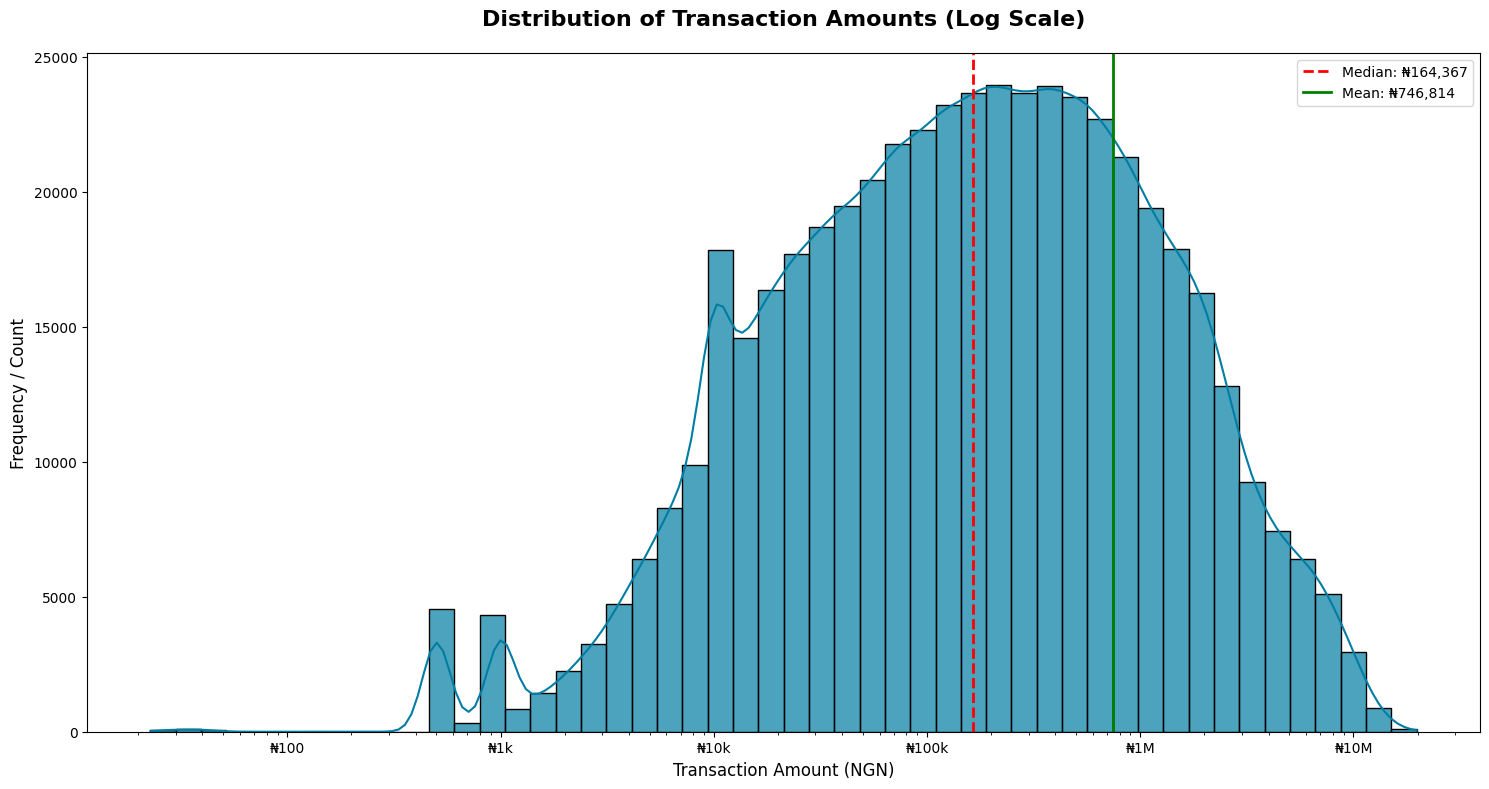

In [7]:
plt.figure(figsize=(15, 8)) 

# Create the Plot with KDE (smooth line)
ax = sns.histplot(
    data=df, 
    x='amount_ngn', 
    bins=50, 
    log_scale=True, 
    kde=True, 
    color='#007da3', 
    edgecolor='black',
    alpha=0.7
)

# Format X-Axis Labels (The most important fix)
# This function converts 100000 -> 100k, 1000000 -> 1M
def human_format(x, pos):
    if x >= 1e6:
        return f'₦{x*1e-6:.0f}M'
    elif x >= 1e3:
        return f'₦{x*1e-3:.0f}k'
    return f'₦{int(x)}'

ax.xaxis.set_major_formatter(ticker.FuncFormatter(human_format))

# Add Vertical Lines for Statistics
median_val = df['amount_ngn'].median()
mean_val = df['amount_ngn'].mean()

plt.axvline(median_val, color='red', linestyle='--', linewidth=2, label=f'Median: ₦{median_val:,.0f}')
plt.axvline(mean_val, color='green', linestyle='-', linewidth=2, label=f'Mean: ₦{mean_val:,.0f}')


plt.title("Distribution of Transaction Amounts (Log Scale)", fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Transaction Amount (NGN)", fontsize=12)
plt.ylabel("Frequency / Count", fontsize=12)

# Add Legend and Final Cleanup
plt.legend()
plt.tight_layout()

# Save and Show
plt.savefig(os.path.join(images_dir, "amount_distribution.png"))
plt.show()

##### Time Analysis.

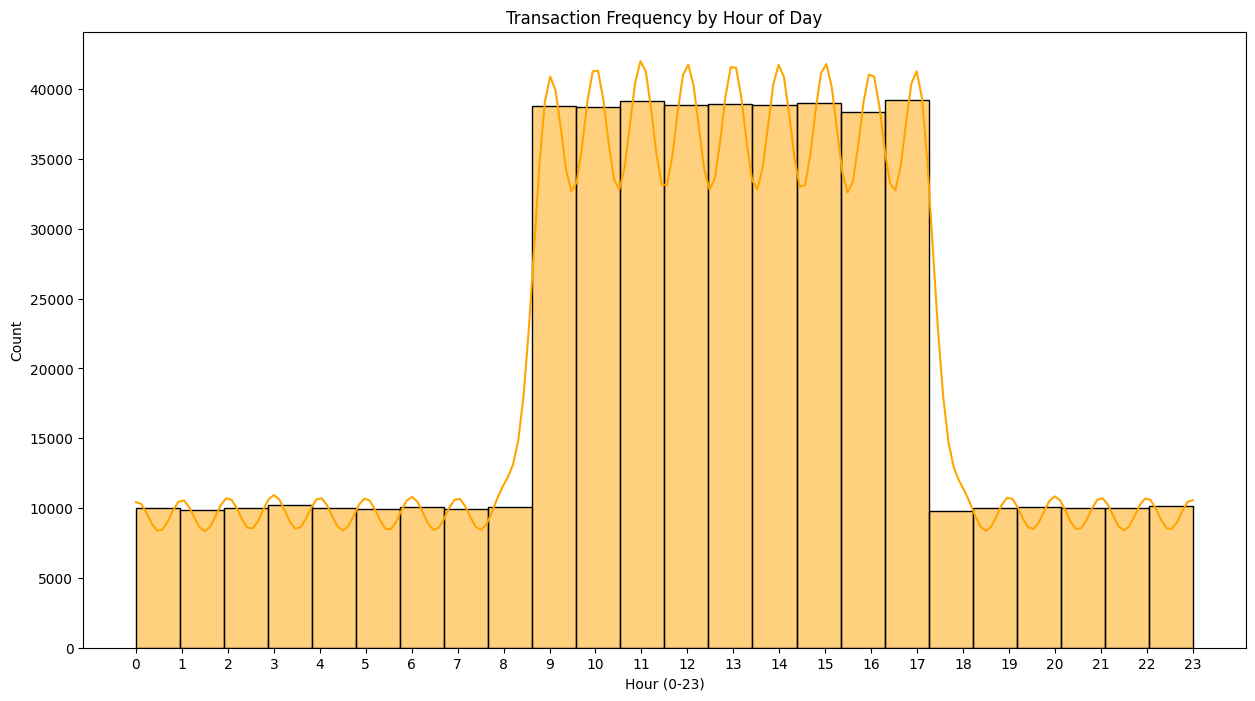

In [8]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour

plt.figure(figsize=(15, 8))
sns.histplot(df['hour'], bins=24, kde=True, color='orange')
plt.title("Transaction Frequency by Hour of Day")
plt.xlabel("Hour (0-23)")
plt.xticks(range(0, 24))
plt.savefig(os.path.join(images_dir, "transaction_frequency.png" ))
plt.show()

##### Top 10 Banks